In [85]:
import torch
import numpy as np
import librosa
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import euclidean_distances
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

from hparams import create_hparams
from test_data_class import TestTextMelCollate, TestTextMelLoader
from model_utils import (
    load_generator,
    load_model_checkpoint,
    parse_test_batch_generator,
)

In [86]:
def pad_mel_list(gen_list, truth_list):
    mel_list = gen_list + truth_list
    all_mels = [mel for batch in mel_list for mel in batch]
    gen_mels = [mel for batch in gen_list for mel in batch]
    truth_mels = [mel for batch in truth_list for mel in batch]

    max_length = max(mel.size(1) for mel in all_mels)
    padded_gen = [
        F.pad(mel, (0, max_length - mel.size(1)), "constant", 0) for mel in gen_mels
    ]
    padded_truth = [
        F.pad(mel, (0, max_length - mel.size(1)), "constant", 0) for mel in truth_mels
    ]

    return padded_gen, padded_truth

In [87]:
def mfcc_distance(mfcc1, mfcc2):
    dist = euclidean_distances(mfcc1.T, mfcc2.T)
    return np.mean(dist) / 100

In [88]:
def calculate_pcc(mel1, mel2):
    pccs = []
    for i in range(mel1.shape[0]):
        pcc, _ = pearsonr(mel1[i], mel2[i])
        pccs.append(pcc)
    return np.mean(pccs)

In [89]:
def evaluate_mel(mel1, mel2, mfcc_dim=25, exclude_zeroth=True):
    mfcc1 = librosa.feature.mfcc(
        S=librosa.power_to_db(mel1),
        n_mfcc=mfcc_dim,
        n_fft=2048,
        hop_length=200,
        win_length=800,
        window="hann",
        center=True,
        pad_mode="reflect",
    )
    mfcc2 = librosa.feature.mfcc(
        S=librosa.power_to_db(mel2),
        n_mfcc=mfcc_dim,
        n_fft=2048,
        hop_length=200,
        win_length=800,
        window="hann",
        center=True,
        pad_mode="reflect",
    )

    if exclude_zeroth:
        mfcc1 = mfcc1[4:]
        mfcc2 = mfcc2[4:]

    mcd = mfcc_distance(mfcc1, mfcc2)
    pcc = calculate_pcc(mel1, mel2)

    return mcd, pcc

In [90]:
hparams = create_hparams()
test_dataset = TestTextMelLoader("./data/ESD/test.csv", hparams, mixed_training=True)
collate_fn = TestTextMelCollate(hparams.n_frames_per_step)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    collate_fn=collate_fn,
    shuffle=False,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [91]:
model = load_generator(hparams, device)
model_file = "/home/xzodia/dev/emo-gan/outputs/train_gan/train_6/generator/checkpoint_epoch_100.pth.tar"
model = load_model_checkpoint(model_file, model)

In [92]:
male_speaker_mcd = {}
male_speaker_pcc = {}
female_speaker_mcd = {}
female_speaker_pcc = {}

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y, z = parse_test_batch_generator(batch)

        (
            text_padded,
            _,
            emotion_vectors,
            _,
            _,
        ) = x

        real_mel, _, _ = y

        _, emotion, speaker = z

        mel_outputs, mel_outputs_postnet, gate_outputs, alignments = model.inference(
            text_padded, emotion_vectors
        )

        gen_mel, real_mel = pad_mel_list([mel_outputs_postnet], [real_mel])

        mcd, pcc = evaluate_mel(gen_mel[0].cpu().numpy(), real_mel[0].cpu().numpy())

        if speaker[0] == "13" and emotion[0] != "Surprise":
            if emotion[0] in male_speaker_mcd:
                male_speaker_mcd[emotion[0]] += mcd
                male_speaker_pcc[emotion[0]] += pcc
            else:
                male_speaker_mcd[emotion[0]] = mcd
                male_speaker_pcc[emotion[0]] = pcc
        elif speaker[0] == "19" and emotion[0] != "Surprise":
            if emotion[0] in female_speaker_mcd:
                female_speaker_mcd[emotion[0]] += mcd
                female_speaker_pcc[emotion[0]] += pcc
            else:
                female_speaker_mcd[emotion[0]] = mcd
                female_speaker_pcc[emotion[0]] = pcc

for key in male_speaker_mcd:
    male_speaker_mcd[key] /= 20
    female_speaker_mcd[key] /= 20

100%|██████████| 160/160 [00:25<00:00,  6.24it/s]


In [93]:
print(male_speaker_mcd)
print(male_speaker_pcc)

{'Sad': 1.8728487548828123, 'Happy': 2.1406163940429694, 'Angry': 1.9488243713378903}
{'Sad': 0.4511904981574806, 'Happy': -0.5576417588583176, 'Angry': 0.8918859661412798}


In [94]:
print(female_speaker_mcd)
print(female_speaker_pcc)

{'Happy': 2.1373530578613282, 'Sad': 1.7551808700561522, 'Angry': 2.0072423934936525}
{'Happy': 0.05928032237940828, 'Sad': -0.12223782525607303, 'Angry': 0.6623694926911761}


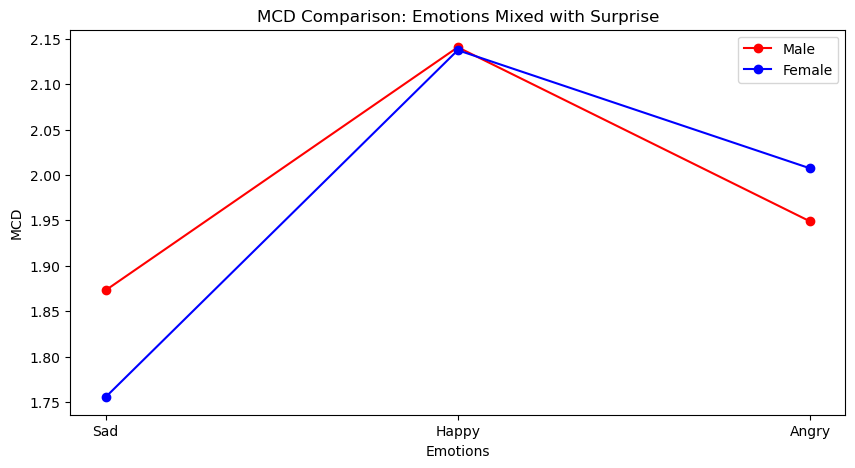

In [95]:
emotions = male_speaker_mcd.keys()

male_sorted_values = [male_speaker_mcd[emotion] for emotion in emotions]
female_sorted_values = [female_speaker_mcd[emotion] for emotion in emotions]

plt.figure(figsize=(10, 5))
plt.plot(
    emotions,
    male_sorted_values,
    "ro-",
    label="Male",
)
plt.plot(
    emotions,
    female_sorted_values,
    "bo-",
    label="Female",
)
plt.xlabel("Emotions")
plt.ylabel("MCD")
plt.title("MCD Comparison: Emotions Mixed with Surprise")
plt.legend()
plt.show()

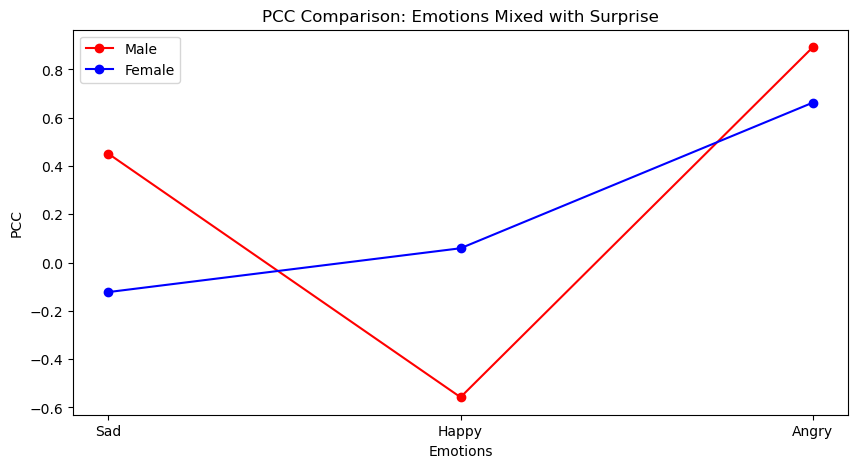

In [96]:
emotions = male_speaker_mcd.keys()

male_sorted_values = [male_speaker_pcc[emotion] for emotion in emotions]
female_sorted_values = [female_speaker_pcc[emotion] for emotion in emotions]

plt.figure(figsize=(10, 5))
plt.plot(
    emotions,
    male_sorted_values,
    "ro-",
    label="Male",
)
plt.plot(
    emotions,
    female_sorted_values,
    "bo-",
    label="Female",
)
plt.xlabel("Emotions")
plt.ylabel("PCC")
plt.title("PCC Comparison: Emotions Mixed with Surprise")
plt.legend()
plt.show()